Importing necessary libraries

In [1]:
from sklearn import datasets
import pandas as pd
import seaborn as sns
from statsmodels.stats import weightstats as stests
import statsmodels.api as sm
from statsmodels.formula.api import ols
import warnings
warnings.simplefilter('ignore')


Loading dataset

In [2]:
#Iris dataset for classification
iris = datasets.load_iris()
iris_pd = pd.DataFrame(data=iris.data) #Converting to dataframe
iris_pd.columns = iris.feature_names #Feature names
iris_pd['Class'] = iris.target #Target variable
iris_pd

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),Class
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,2
146,6.3,2.5,5.0,1.9,2
147,6.5,3.0,5.2,2.0,2
148,6.2,3.4,5.4,2.3,2


In [3]:
#California dataset for regression
from sklearn.datasets import fetch_california_housing
housing = fetch_california_housing()
california_pd = pd.DataFrame(data=housing.data)
california_pd.columns = housing.feature_names
california_pd['MedHouseVal'] = housing.target

<Axes: >

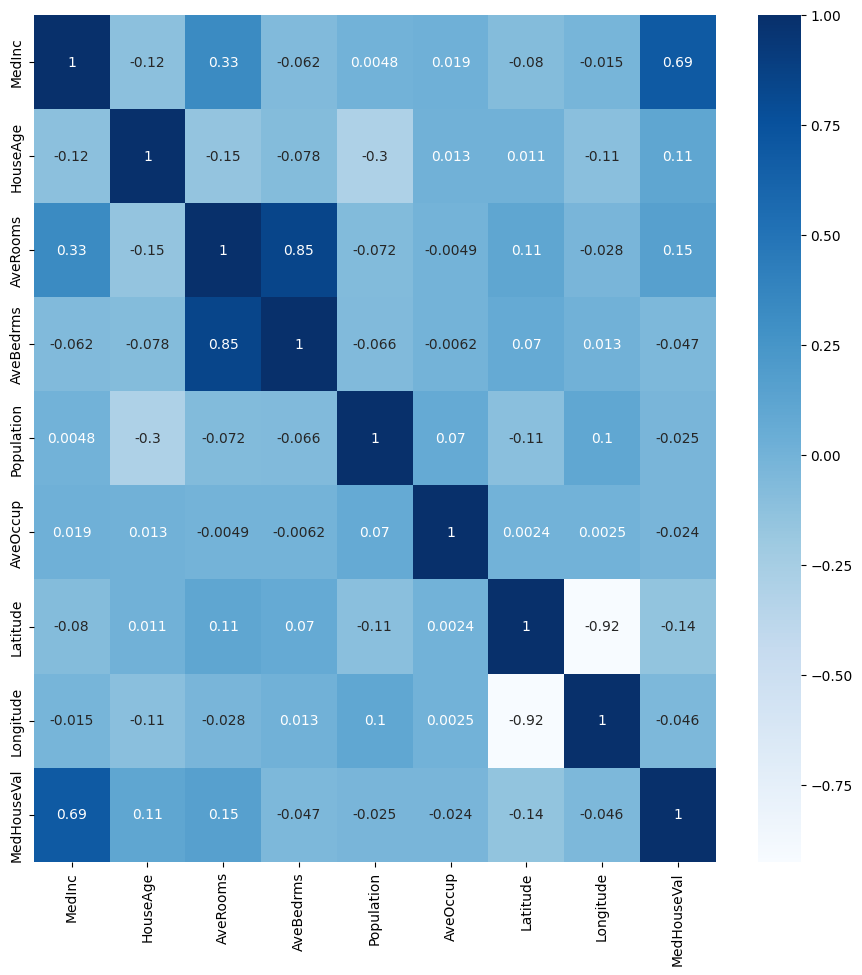

In [4]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(11,11)) #Sample figsize in inches, change the number accordingly
sns.heatmap(california_pd.corr(method = 'pearson'), annot=True, cmap='Blues', ax=ax)

#MEDV and LSTAT is having -0.85, we might need to remove one variable

Variance Inflation Factors

In [5]:
#Import library for VIF
from statsmodels.stats.outliers_influence import variance_inflation_factor

def calc_vif(X):
  vif = pd.DataFrame()
  vif["variables"] = X.columns
  vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
  return(vif)

#Remove dependant column first and then apply VIF
X = california_pd.iloc[:,:-1]
calc_vif(X)

,variables,VIF
0,MedInc,11.511140
1,HouseAge,7.195917
2,AveRooms,45.993601
3,AveBedrms,43.590314
4,Population,2.935745
5,AveOccup,1.095243
6,Latitude,559.874071
7,Longitude,633.711654


Interpreting VIF Values-
The key is to understand what a high VIF means for your model's coefficients:
* VIF = 1:
The predictor variable is not correlated with any other predictors in the model; it is perfectly independent.
* VIF > 1:
Indicates some degree of correlation between the predictor and other predictors, which inflates the variance of the coefficient estimate.
* VIF > 5 (or > 4):
Often considered a sign of potential multicollinearity, requiring further investigation.
* VIF > 10:
Suggests significant multicollinearity, indicating that the variance of the coefficient is too inflated and needs to be corrected to ensure reliable analysis.

## CHI SQUARE TEST

In [6]:
iris_pd.describe()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),Class
count,150.000000,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.057333,3.758000,1.199333,1.000000
std,0.828066,0.435866,1.765298,0.762238,0.819232
min,4.300000,2.000000,1.000000,0.100000,0.000000
25%,5.100000,2.800000,1.600000,0.300000,0.000000
50%,5.800000,3.000000,4.350000,1.300000,1.000000
75%,6.400000,3.300000,5.100000,1.800000,2.000000
max,7.900000,4.400000,6.900000,2.500000,2.000000


In [7]:
iris_pd.dtypes #Listing datatypes of the iris dataset columns

,0
sepal length (cm),float64
sepal width (cm),float64
petal length (cm),float64
petal width (cm),float64
Class,int64


In [8]:
iris_pd['petal width (cm)'].describe()

,petal width (cm)
count,150.000000
mean,1.199333
std,0.762238
min,0.100000
25%,0.300000
50%,1.300000
75%,1.800000
max,2.500000


In [9]:
bin_labels = ['Low', 'High']
iris_pd["Bin_Petal_Width"] = pd.qcut(iris_pd["petal width (cm)"], q=[0,0.5,1], labels=bin_labels)
iris_pd.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),Class,Bin_Petal_Width
0,5.1,3.5,1.4,0.2,0,Low
1,4.9,3.0,1.4,0.2,0,Low
2,4.7,3.2,1.3,0.2,0,Low
3,4.6,3.1,1.5,0.2,0,Low
4,5.0,3.6,1.4,0.2,0,Low


In [10]:
iris_pd['Bin_Petal_Width'].value_counts() #frequency count

,count
Bin_Petal_Width,
Low,78
High,72


In [11]:
iris_pd['Class'] = iris_pd['Class'].astype('category') #Converting target column to categorical
iris_pd.dtypes

,0
sepal length (cm),float64
sepal width (cm),float64
petal length (cm),float64
petal width (cm),float64
Class,category
Bin_Petal_Width,category


In [12]:
#Check interaction effect between class and bin petal width through chi square test
contingency_table = pd.crosstab(iris_pd['Bin_Petal_Width'],iris_pd['Class'])
contingency_table

Class,0,1,2
Bin_Petal_Width,,,
Low,50,28,0
High,0,22,50


In [13]:
from scipy import stats
chi2_stat, p_val, dof, ex = stats.chi2_contingency(contingency_table)
print("Chi-Square Test Values")
print("Chi-Square value: ", chi2_stat)
print("Degrees of Freedom: ",dof)
print("P-Value: ",p_val) #the very small p-value indicates a strong association between 'Bin_Petal_Width' and 'Class'
contingency_table
ex

Chi-Square Test Values
Chi-Square value:  100.64102564102565
Degrees of Freedom:  2
P-Value:  1.3998417931687032e-22


array([[26., 26., 26.],
       [24., 24., 24.]])

In [14]:
iris_pd.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),Class,Bin_Petal_Width
0,5.1,3.5,1.4,0.2,0,Low
1,4.9,3.0,1.4,0.2,0,Low
2,4.7,3.2,1.3,0.2,0,Low
3,4.6,3.1,1.5,0.2,0,Low
4,5.0,3.6,1.4,0.2,0,Low


<Axes: xlabel='Class', ylabel='sepal width (cm)'>

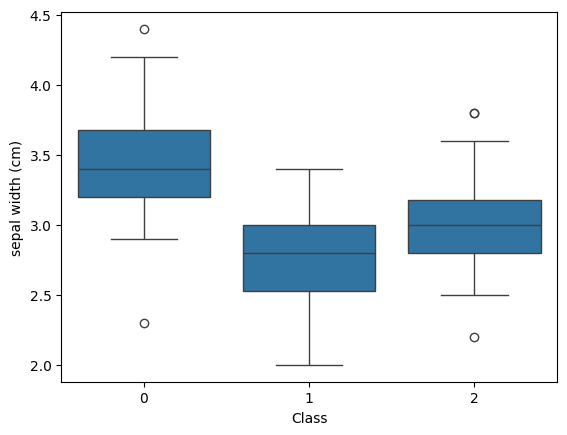

In [15]:
#Plotting the boxplot
sns.boxplot(x='Class', y='sepal width (cm)', data=iris_pd)

## Z-TEST

In [18]:
print("Number of samples in the set: ",len(iris_pd))
print("Therefore using Z-Test, ")

ztest ,pval = stests.ztest(iris_pd['Class'], iris_pd['sepal length (cm)'], alternative='two-sided')
print("Z-Test value is ", ztest)
print("P value is", pval)

#Inference: P-Value is less than 0.05 so reject NULL HYPOTHESIS wihch means Sepal length can be a good predictor for Class

Number of samples in the set:  150
Therefore using Z-Test, 
Z-Test value is  -50.92447470978208
P value is 0.0


In [19]:
#For sepal width
iris_pd["Bin_Sepal_Width"] = pd.qcut(iris_pd["sepal width (cm)"], q=[0,0.5,1], labels=bin_labels)

#Removing space and other symbols in column name to use in a model
iris_pd.columns = iris_pd.columns.str.replace(' ', '')
iris_pd.columns = iris_pd.columns.str.replace('(cm)', '')
iris_pd.columns = iris_pd.columns.str.replace('[^a-zA-Z]', '')

In [20]:
iris_pd['Class'] = iris_pd['Class'].astype('int')

#Building Regression model
model = ols('Class ~ C(Bin_Petal_Width) *C(Bin_Sepal_Width)', iris_pd).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Class   R-squared:                       0.785
Model:                            OLS   Adj. R-squared:                  0.781
Method:                 Least Squares   F-statistic:                     177.8
Date:                Tue, 16 Sep 2025   Prob (F-statistic):           1.55e-48
Time:                        09:31:08   Log-Likelihood:                -67.119
No. Observations:                 150   AIC:                             142.2
Df Residuals:                     146   BIC:                             154.3
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=========================================================================================================================
                                                            coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------------------
Intercept                                                 0.7778      0.064     12.163      0.000       0.651       0.904
C(Bin_Petal_Width)[T.High]                                0.9243      0.085     10.878      0.000       0.756       1.092
C(Bin_Sepal_Width)[T.High]                               -0.7778      0.087     -8.925      0.000      -0.950      -0.606
C(Bin_Petal_Width)[T.High]:C(Bin_Sepal_Width)[T.High]     0.7557      0.129      5.862      0.000       0.501       1.010
==============================================================================
Omnibus:                       25.008   Durbin-Watson:                   1.397
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               33.614
Skew:                          -1.154   Prob(JB):                     5.02e-08
Kurtosis:                       2.776   Cond. No.                         6.52
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Anova Output

In [21]:
sm.stats.anova_lm(model, typ= 2)
#Type=2 because of independent columns
#F = Between group variability / Within Group variability

#Inference: P value>0.05, so reject null hypothesis, so bins in petal width and sepal width on class is statistically significant

,sum_sq,df,F,PR(>F)
C(Bin_Petal_Width),56.590258,1.0,384.430208,9.721071e-43
C(Bin_Sepal_Width),6.675232,1.0,45.346339,3.528236e-10
C(Bin_Petal_Width):C(Bin_Sepal_Width),5.059254,1.0,34.368636,2.919685e-08
Residual,21.492009,146.0,NaN,NaN
